In [1]:
import pickle
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from project_helper import FuturesCloseData, VolFeatures, TradeModel
import matplotlib.pyplot as plt
#import graphviz

In [2]:
svd_df_daily = pd.read_csv('combined_svd_df.csv',names=['index','svd_1','svd_2','date'], index_col = 0, skiprows = 1)
svd_df_daily.set_index('date', inplace = True)
svd_df_daily.index = pd.to_datetime(svd_df_daily.index) + timedelta(days=-1)
svd_df_daily.head()

,svd_1,svd_2
date,,
2009-05-04,0.231291,0.194568
2009-05-07,0.052782,0.062221
2009-05-08,0.079785,0.035236
2009-05-11,0.098248,0.041978
2009-05-12,0.069910,0.062147


In [3]:
intraday = pd.read_csv('features/intraday.csv', names= ['date','ret'])
intraday.set_index('date', inplace = True)

In [4]:
fc = FuturesCloseData()
fc.returns('ES').head()

date
2014-01-02   -0.002707
2014-01-03    0.005713
2014-01-06    0.000994
2014-01-07    0.000284
2014-01-08    0.002695
Name: ES, dtype: float64

In [5]:
vol = VolFeatures()
vol.features('ES').head()

,ES_1M_atm_vol,ES_1M_RR25,ES_1M_RR10,ES_1M_Fly25,ES_1M_Fly10,ES_2M_atm_vol,ES_2M_RR25,ES_2M_RR10,ES_2M_Fly25,ES_2M_Fly10,ES_2M_1M_atm_vol
Date,,,,,,,,,,,
2016-11-14,0.119889,-0.037174,-0.073479,0.003789,0.015547,0.125210,-0.046645,-0.088709,0.004540,0.017257,0.005205
2016-11-15,0.097407,-0.019810,-0.038827,0.004464,0.018210,0.116007,-0.037339,-0.070383,0.004491,0.016703,0.018506
2016-11-16,0.086325,-0.015557,-0.032338,0.003478,0.014565,0.118026,-0.039720,-0.075981,0.004275,0.016356,0.031726
2016-11-17,0.078008,-0.013282,-0.026062,0.003378,0.013855,0.114574,-0.037722,-0.072023,0.003713,0.014712,0.036573
2016-11-18,0.062015,-0.009879,-0.019785,0.002611,0.011093,0.110443,-0.037831,-0.073675,0.002989,0.013092,0.048422


In [16]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
X_dict = {}
y_dict = {}
date_min = pd.to_datetime('2016-11-14')
date_max = pd.to_datetime('2019-09-25')
for inst in instrument_list:
    X = intraday.join(svd_df_daily).join(fc.features(inst)).join(vol.features(inst)).dropna()
    X = X[(X.index >= date_min) & (X.index <= date_max)]
    X_dict[inst] = X
    y_dict[inst] = fc.returns(inst)[X.index]


X_dict

In [7]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'C', 'S', 'W', 'CL']
strat_sharpes = {}
strat_rets = {}
strat_cum_rets = {}
strat_models = {}
for inst in instrument_list:
    y = 2 * (y_dict[inst]>= 0) - 1
    X_train, X_test, y_train, y_test = train_test_split(X_dict[inst], y, test_size=0.50, shuffle=False )
    tm = TradeModel(n_estimators=1000, max_features=10, max_depth=15, criterion ='entropy')
    tm.fit(X_train, y_train)
    strat_models[inst] = tm
    strat_rets[inst], strat_cum_rets[inst] = tm.strategy_returns(X_test, y_dict[inst][-len(X_test):], cutoff=0.55)
    strat_sharpes[inst] = tm.sharpe(X_test, y_dict[inst][-len(X_test):],cutoff=0.55)
    print('{} sharpe {}:'.format(inst, strat_sharpes[inst]))
    

ES sharpe 0.04980873853662025:
NQ sharpe -0.06191460631236289:
CD sharpe 0.015587771366487816:
EC sharpe 0.04333169076456793:
JY sharpe 0.0779069628119528:
MP sharpe -0.03260696906439566:
C sharpe 0.055931271428162614:
S sharpe -0.04349115063092906:
W sharpe 0.00984457477895094:
CL sharpe -0.0020594290147968415:


C:\Users\PC\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


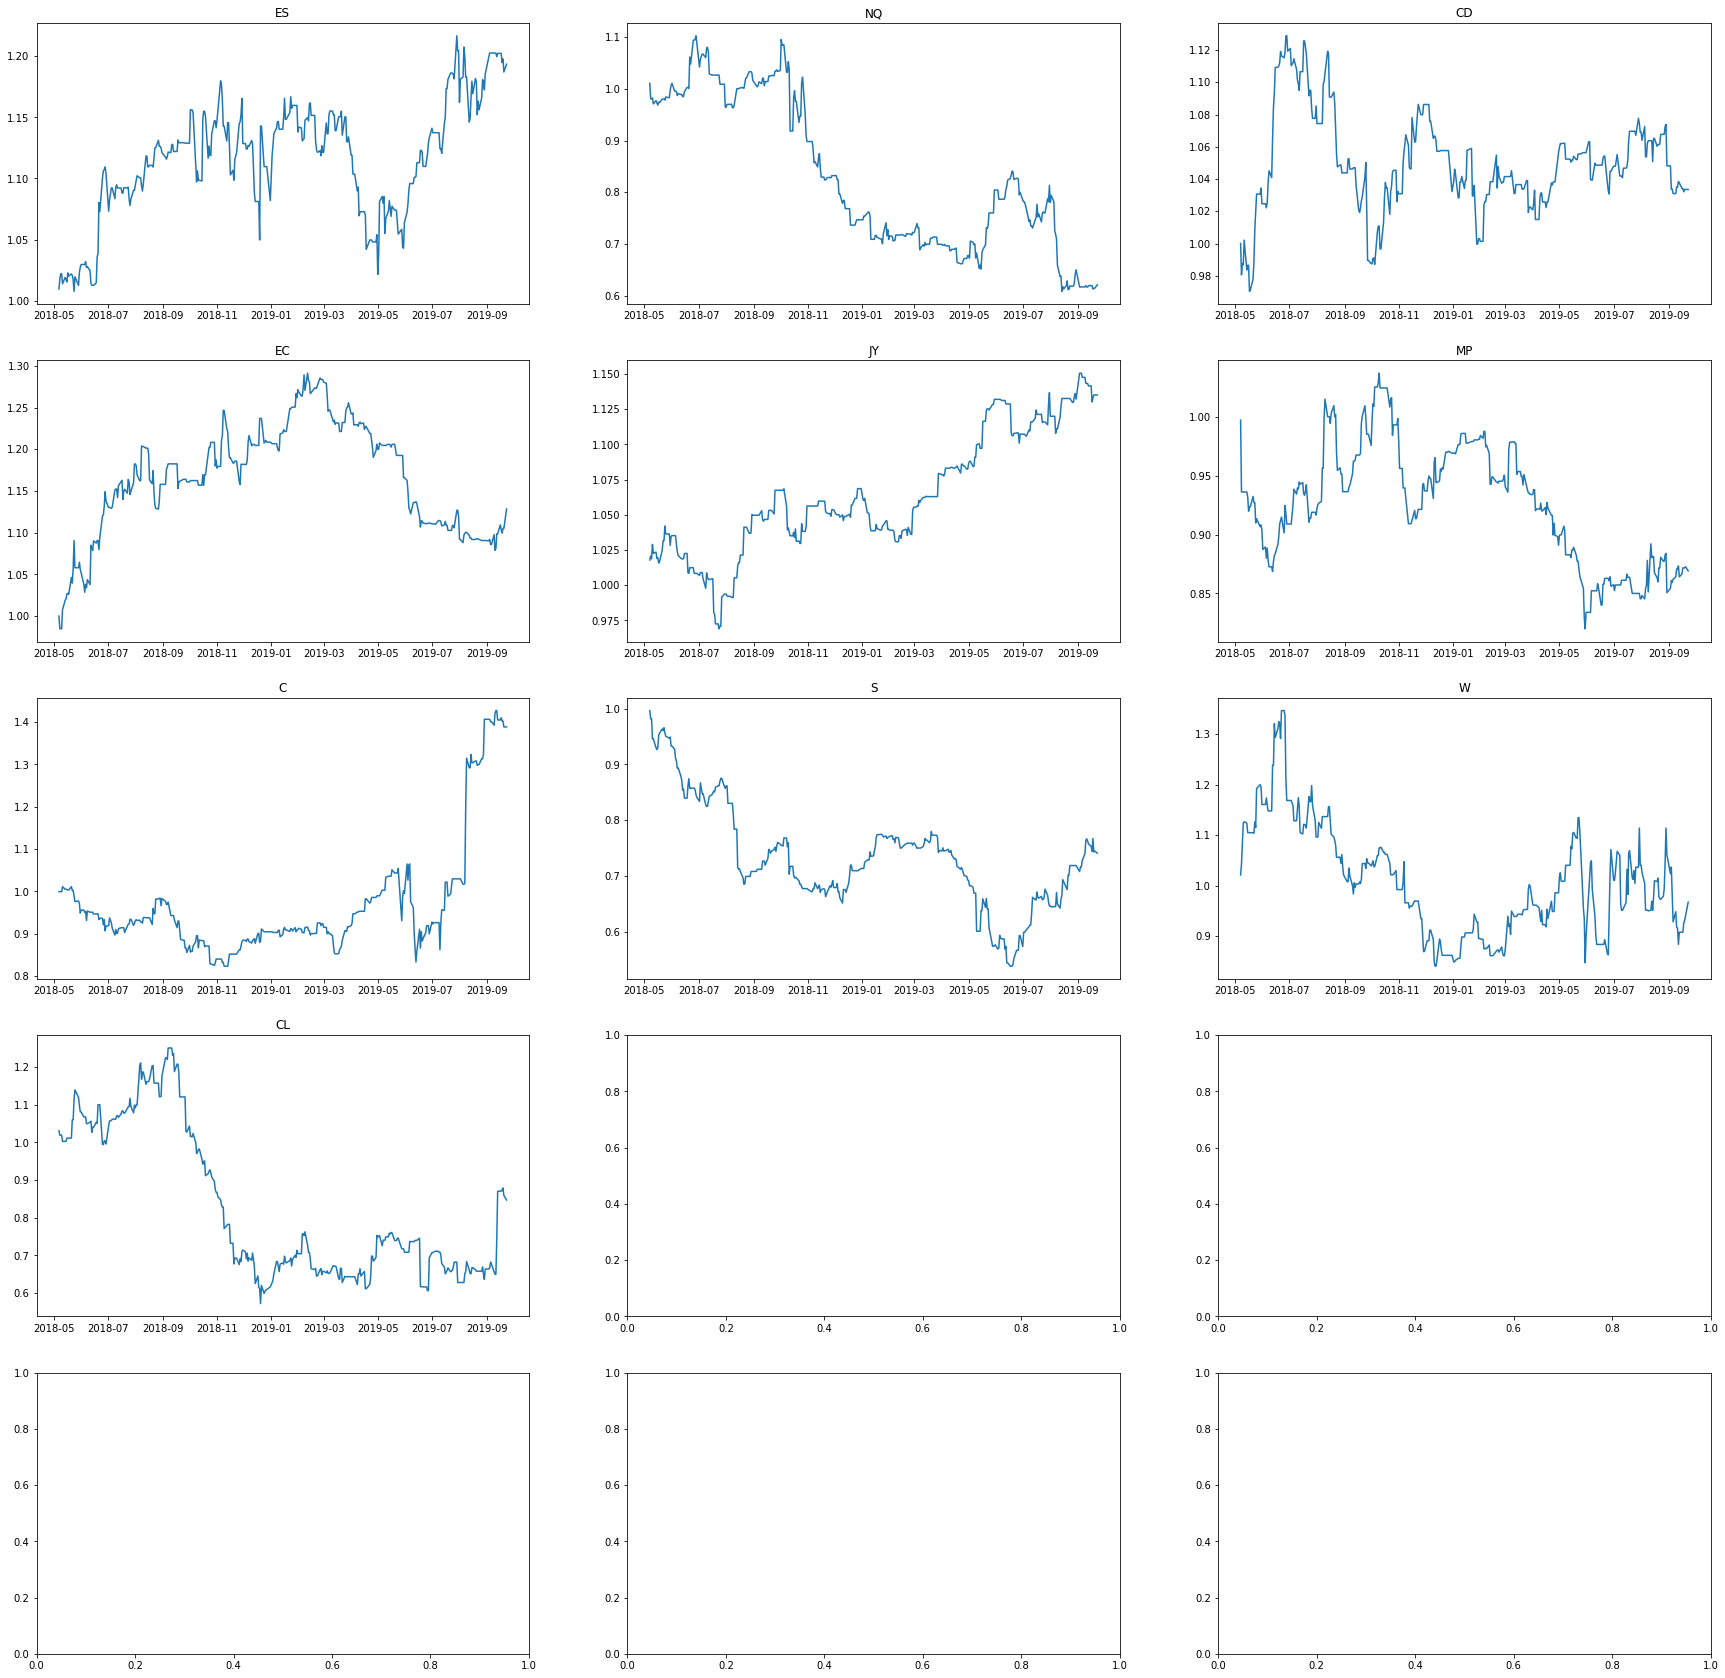

In [8]:
fig, ax = plt.subplots(5,3,figsize=(30,30))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(strat_cum_rets[inst])
    ax[i].set_title(inst)


0.009640096661772426


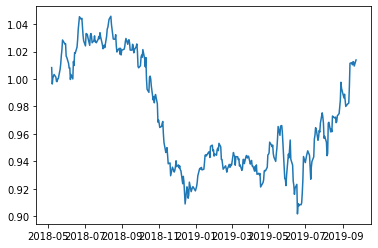

In [9]:
port_rets = pd.DataFrame(strat_rets).mean(axis=1)
plt.plot((1 + pd.DataFrame(strat_rets).mean(axis=1)).cumprod())
print(port_rets.mean()/port_rets.std())

In [10]:
strat_models['NQ'].model.feature_importances_

array([0.10525231, 0.08233016, 0.09017401, 0.07671507, 0.05930007,
       0.0505724 , 0.06761276, 0.0555302 , 0.05968327, 0.05881642,
       0.05015743, 0.05116841, 0.06873266, 0.06066822, 0.06328661])

In [11]:
strat_sharpes

{'ES': 0.04980873853662025,
 'NQ': -0.06191460631236289,
 'CD': 0.015587771366487816,
 'EC': 0.04333169076456793,
 'JY': 0.0779069628119528,
 'MP': -0.03260696906439566,
 'C': 0.055931271428162614,
 'S': -0.04349115063092906,
 'W': 0.00984457477895094,
 'CL': -0.0020594290147968415}

In [12]:
'''
dot_data = export_graphviz(tree, out_file=None, 
                      feature_names=X_train.columns,  
                     class_names=[str(1),str(-1)],  
                     filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 
'''

'\ndot_data = export_graphviz(tree, out_file=None, \n                      feature_names=X_train.columns,  \n                     class_names=[str(1),str(-1)],  \n                     filled=True, rounded=True,  \n                    special_characters=True)  \ngraph = graphviz.Source(dot_data)  \ngraph \n'

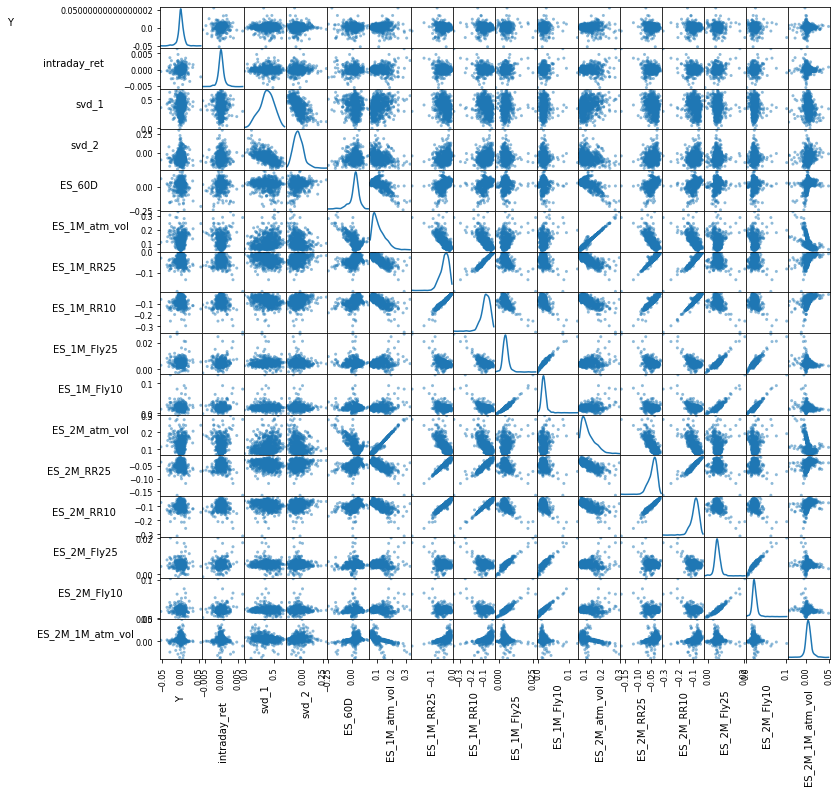

In [28]:
from pandas.plotting import scatter_matrix
mat = pd.DataFrame(y_dict['ES']).join(X_dict['ES'])
mat = mat.rename(columns = {'ES':'Y', 'ret':'intraday_ret'})
axs = scatter_matrix(mat,figsize=(12, 12), diagonal='kde');
n = len(mat.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50